In [4]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("HuggingFaceTB/Countdown-Task-GOLD", "verified_Qwen3-4B-Instruct-2507")

for split, dataset in ds.items():
    dataset.to_json(f"{split}.jsonl", orient="records", lines=True)

Creating json from Arrow format: 100%|██████████| 28/28 [00:00<00:00, 57.92ba/s]


In [5]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("HuggingFaceTB/Countdown-Task-GOLD", "test")

for split, dataset in ds.items():
    dataset.to_json(f"test.jsonl", orient="records", lines=True)

Creating json from Arrow format: 100%|██████████| 10/10 [00:00<00:00, 170.38ba/s]


In [6]:
from datasets import load_dataset

path = "/data/shanghong/oumi/gold/train_verified_Qwen3-4B-Instruct-2507.jsonl"

# Load JSONL
ds = load_dataset("json", data_files=path, split="train")

# 90/10 split
split_ds = ds.train_test_split(test_size=0.1, seed=42)

train_ds = split_ds["train"]
val_ds = split_ds["test"]

print(train_ds, val_ds)

train_ds.to_json(
    "/data/shanghong/oumi/gold/train_90.jsonl",
    orient="records",
    lines=True
)

val_ds.to_json(
    "/data/shanghong/oumi/gold/val_10.jsonl",
    orient="records",
    lines=True
)


Generating train split: 27667 examples [00:00, 235869.07 examples/s]


Dataset({
    features: ['target', 'nums', 'messages'],
    num_rows: 24900
}) Dataset({
    features: ['target', 'nums', 'messages'],
    num_rows: 2767
})


Creating json from Arrow format: 100%|██████████| 3/3 [00:00<00:00, 40.00ba/s]


5620932

In [3]:
from datasets import load_dataset

path = "/data/shanghong/oumi/gold/data/train_90.jsonl"

# Load JSONL
ds = load_dataset("json", data_files=path, split="train")

# Shuffle for randomness
ds = ds.shuffle(seed=42)

# Take a small subset
train_ds = ds.select(range(128))   # change 128 → 256 / 512 as needed

print(train_ds)

# Save
train_ds.to_json(
    "/data/shanghong/oumi/gold/data/train_small_128.jsonl",
    orient="records",
    lines=True
)


Generating train split: 24900 examples [00:00, 223603.30 examples/s]


Dataset({
    features: ['target', 'nums', 'messages'],
    num_rows: 128
})


Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 161.22ba/s]


262786

In [32]:
import json

input_path = "/data/shanghong/oumi/gold/output/qwen2.5_1.5b_baseline.jsonl"
test_path = "/data/shanghong/oumi/gold/data/test.jsonl"
output_path = "/data/shanghong/oumi/gold/output/qwen2.5_1.5b_baseline.jsonl"

# with open(input_path, "r", encoding="utf-8") as f:
#     data = json.load(f)

with open(input_path, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

test_data = []
with open(test_path, "r") as f:
    for line in f:
        test_data.append(json.loads(line))

for item, test_item in zip(data, test_data):
    item["target"] = test_item["target"]
    item["nums"] = test_item["nums"]


with open(output_path, "w", encoding="utf-8") as f:
    for item in data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")


In [4]:
import json
import numpy as np
from transformers import AutoTokenizer

train_data = []
with open("/data/shanghong/oumi/gold/data/train_90.jsonl", "r") as f:
    for line in f:
        train_data.append(json.loads(line))

completions = []
for item in train_data:
    assert item["messages"][-1]["role"] == "assistant"
    completions.append(item["messages"][-1]["content"])

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "Qwen/Qwen3-4B-Instruct-2507",
    trust_remote_code=True,
)

# tokenize and compute lengths
lengths = [
    len(tokenizer.encode(c, add_special_tokens=False))
    for c in completions
]

lengths = np.array(lengths)

print(f"Number of samples: {len(lengths)}")
print(f"Average completion length (tokens): {lengths.mean():.2f}")
print(f"Median (p50): {np.percentile(lengths, 50):.0f}")
print(f"P90: {np.percentile(lengths, 90):.0f}")
print(f"P95: {np.percentile(lengths, 95):.0f}")
print(f"Max: {lengths.max()}")


Number of samples: 24900
Average completion length (tokens): 550.33
Median (p50): 379
P90: 1198
P95: 1568
Max: 2048


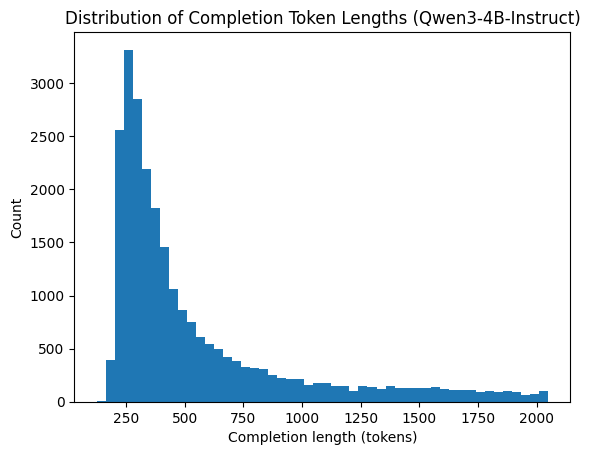

In [6]:
import matplotlib.pyplot as plt
lengths = np.array(lengths)

# Plot distribution
plt.figure()
plt.hist(lengths, bins=50)
plt.xlabel("Completion length (tokens)")
plt.ylabel("Count")
plt.title("Distribution of Completion Token Lengths (Qwen3-4B-Instruct)")
plt.show()

In [14]:
with open("/data/shanghong/oumi/gold/output/qwen2.5_7b_baseline_judged.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

json.dump(data, open("/data/shanghong/oumi/gold/output/qwen2.5_7b_baseline_judged.json", "w"), indent=4)

In [54]:
import json
import glob
import pandas as pd
from pathlib import Path



summary_dir = "/data/shanghong/oumi/gold/output"
pattern = "*_summary_pass@4.json"

rows = []
for path in glob.glob(str(Path(summary_dir) / pattern)):
    with open(path, "r", encoding="utf-8") as f:
        obj = json.load(f)

    row = {
        "file": Path(path).name,
        "model": Path(path).name.replace("_summary_pass@4.json", ""),
        "n": obj["n"],
        "total_rows": obj["total_rows"],
        "valid_rows": obj["valid_rows"],
        "passed_rows": obj["passed_rows"],
        "pass@n": obj["pass@n"],
    }

    # flatten failure breakdown
    for k, v in obj.get("failure_breakdown", {}).items():
        row[f"fail_{k}"] = v

    rows.append(row)

df = pd.DataFrame(rows)

order = [
    "qwen2.5_1.5b_baseline",
    "qwen2.5_1.5b_ckpt500",
    "qwen2.5_1.5b_ckpt1000",
    "qwen2.5_1.5b_ckpt1500",
    "qwen2.5_1.5b_ckpt1700",
    "qwen2.5_1.5b_ckpt2000",
    "qwen2.5_1.5b_ckpt3000",
    "qwen3_4b_baseline"
]

df = pd.DataFrame(rows).fillna(0)
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)
df = df.sort_values("model")

display(df)


,file,model,n,total_rows,valid_rows,passed_rows,pass@n,fail_missing_answer_tags,fail_invalid_number_usage,fail_equation_not_balanced,fail_lhs_parse_or_eval_error,fail_rhs_parse_or_eval_error,fail_wrong_value
3,qwen2.5_1.5b_baseline_summary_pass@4.json,qwen2.5_1.5b_baseline,4,10000,10000,1482,0.1482,1109,3582,2817.0,921,36.0,53
6,qwen2.5_1.5b_ckpt500_summary_pass@4.json,qwen2.5_1.5b_ckpt500,4,10000,10000,7306,0.7306,1439,237,389.0,499,4.0,126
4,qwen2.5_1.5b_ckpt1000_summary_pass@4.json,qwen2.5_1.5b_ckpt1000,4,10000,10000,8022,0.8022,1371,223,188.0,112,5.0,79
7,qwen2.5_1.5b_ckpt1500_summary_pass@4.json,qwen2.5_1.5b_ckpt1500,4,10000,10000,8114,0.8114,1616,76,108.0,62,6.0,18
0,qwen2.5_1.5b_ckpt1700_summary_pass@4.json,qwen2.5_1.5b_ckpt1700,4,10000,10000,7947,0.7947,1657,131,131.0,112,1.0,21
5,qwen2.5_1.5b_ckpt2000_summary_pass@4.json,qwen2.5_1.5b_ckpt2000,4,10000,10000,7789,0.7789,1366,270,209.0,310,9.0,47
1,qwen2.5_1.5b_ckpt3000_summary_pass@4.json,qwen2.5_1.5b_ckpt3000,4,10000,10000,7713,0.7713,1384,288,195.0,349,4.0,67
2,qwen3_4b_baseline_summary_pass@4.json,qwen3_4b_baseline,4,10000,10000,8838,0.8838,988,160,0.0,11,0.0,3


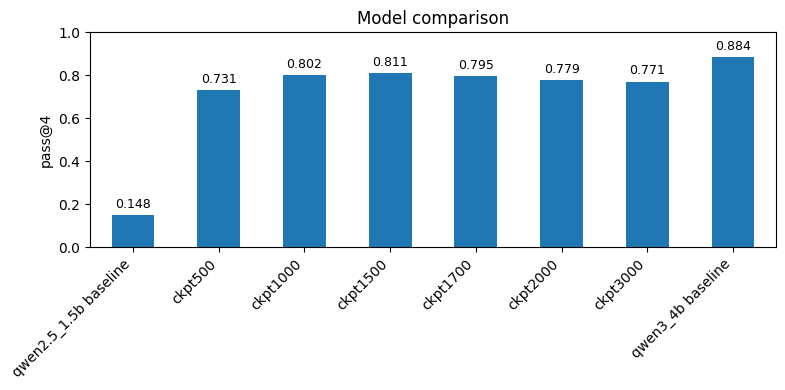

In [55]:
import re
import matplotlib.pyplot as plt

# Prepare data
df_plot = df[["model", "pass@n"]].copy()

def short_name(m):
    if "ckpt" in m:
        return re.search(r"(ckpt\d+)", m).group(1)
    return m.replace("_baseline", " baseline")

df_plot["label"] = df_plot["model"].apply(short_name)

# Plot
ax = df_plot.plot(
    x="label",
    y="pass@n",
    kind="bar",
    legend=False,
    figsize=(8, 4)
)

ax.set_ylabel("pass@4")
ax.set_title("Model comparison")
ax.set_ylim(0, 1)

# Add values on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.3f}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=9,
        xytext=(0, 3),
        textcoords="offset points",
    )

ax.set_xlabel("")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


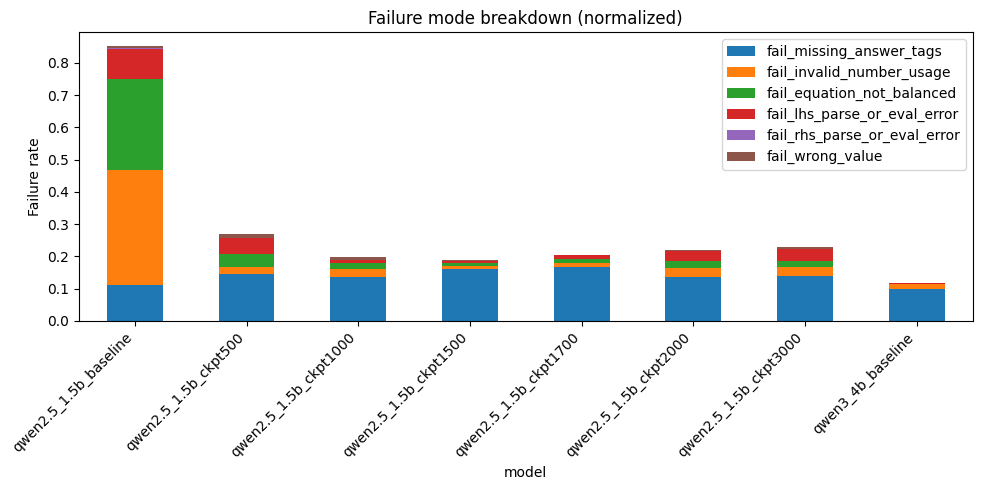

In [56]:
fail_cols = [c for c in df.columns if c.startswith("fail_")]

fail_df = df[fail_cols].div(df["valid_rows"], axis=0)

fail_df.index = df["model"]

fail_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 5)
)

plt.ylabel("Failure rate")
plt.title("Failure mode breakdown (normalized)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


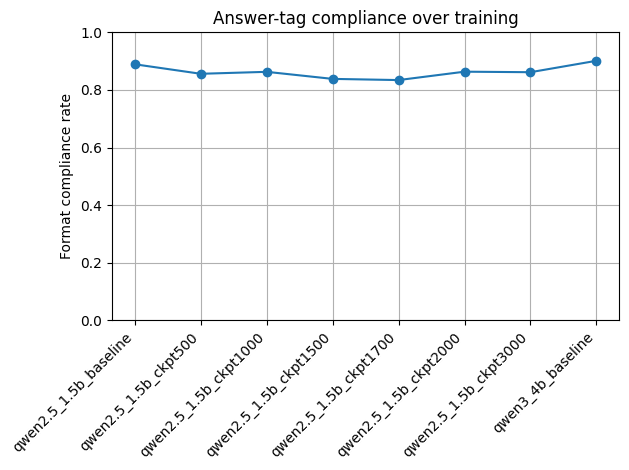

In [46]:
format_ok = 1 - df["fail_missing_answer_tags"] / df["valid_rows"]
plt.figure()
plt.plot(df["model"], format_ok, marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Format compliance rate")
plt.title("Answer-tag compliance over training")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


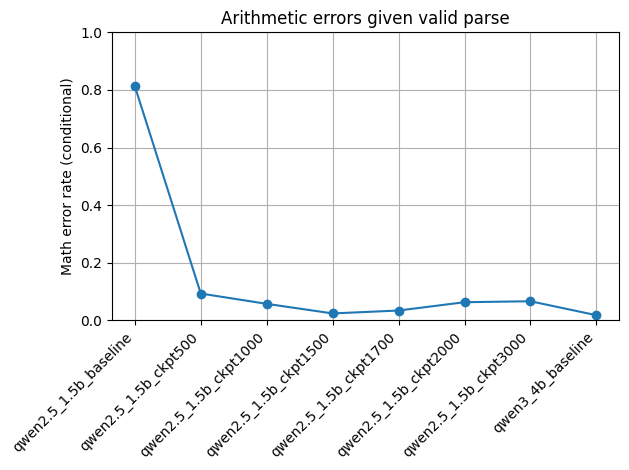

In [57]:
parsable = df["valid_rows"] - (
    df["fail_missing_answer_tags"]
    + df["fail_lhs_parse_or_eval_error"]
    + df["fail_rhs_parse_or_eval_error"]
)

math_fail = (
    df["fail_wrong_value"]
    + df["fail_equation_not_balanced"]
    + df["fail_invalid_number_usage"]
)

math_error_rate = math_fail / parsable

plt.figure()
plt.plot(df["model"], math_error_rate, marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Math error rate (conditional)")
plt.title("Arithmetic errors given valid parse")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()



In [51]:
import json
import glob
import pandas as pd
from pathlib import Path

summary_dir = "/data/shanghong/oumi/gold/output"
pattern = "*_summary_pass@1.json"

rows = []
for path in glob.glob(str(Path(summary_dir) / pattern)):
    with open(path, "r", encoding="utf-8") as f:
        obj = json.load(f)

    row = {
        "file": Path(path).name,
        "model": Path(path).name.replace("_summary_pass@1.json", ""),
        "n": obj["n"],
        "total_rows": obj["total_rows"],
        "valid_rows": obj["valid_rows"],
        "passed_rows": obj["passed_rows"],
        "pass@n": obj["pass@n"],
    }

    # flatten failure breakdown
    for k, v in obj.get("failure_breakdown", {}).items():
        row[f"fail_{k}"] = v

    rows.append(row)

df = pd.DataFrame(rows)

order = [
    "qwen2.5_1.5b_baseline",
    "qwen2.5_1.5b_ckpt500",
    "qwen2.5_1.5b_ckpt1000",
    "qwen2.5_1.5b_ckpt1500",
    "qwen2.5_1.5b_ckpt1700",
    "qwen2.5_1.5b_ckpt2000",
    "qwen2.5_1.5b_ckpt3000",
    "qwen3_4b_baseline"
]

df = pd.DataFrame(rows).fillna(0)
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)
df = df.sort_values("model")

display(df)


,file,model,n,total_rows,valid_rows,passed_rows,pass@n,fail_missing_answer_tags,fail_wrong_value,fail_lhs_parse_or_eval_error,fail_equation_not_balanced,fail_invalid_number_usage,fail_rhs_parse_or_eval_error
4,qwen2.5_1.5b_baseline_summary_pass@1.json,qwen2.5_1.5b_baseline,1,10000,10000,418,0.0418,1249,63,1032,3135.0,4060,43.0
6,qwen2.5_1.5b_ckpt500_summary_pass@1.json,qwen2.5_1.5b_ckpt500,1,10000,10000,4846,0.4846,1975,233,1517,929.0,464,36.0
7,qwen2.5_1.5b_ckpt1000_summary_pass@1.json,qwen2.5_1.5b_ckpt1000,1,10000,10000,6140,0.6140,2026,167,726,473.0,459,9.0
2,qwen2.5_1.5b_ckpt1500_summary_pass@1.json,qwen2.5_1.5b_ckpt1500,1,10000,10000,6776,0.6776,2337,54,383,260.0,178,12.0
5,qwen2.5_1.5b_ckpt1700_summary_pass@1.json,qwen2.5_1.5b_ckpt1700,1,10000,10000,5994,0.5994,2303,35,1026,364.0,274,4.0
0,qwen2.5_1.5b_ckpt2000_summary_pass@1.json,qwen2.5_1.5b_ckpt2000,1,10000,10000,5254,0.5254,1838,237,1586,485.0,576,24.0
3,qwen2.5_1.5b_ckpt3000_summary_pass@1.json,qwen2.5_1.5b_ckpt3000,1,10000,10000,5217,0.5217,1868,233,1578,465.0,622,17.0
1,qwen3_4b_baseline_summary_pass@1.json,qwen3_4b_baseline,1,10000,10000,8021,0.8021,1631,4,25,0.0,319,0.0


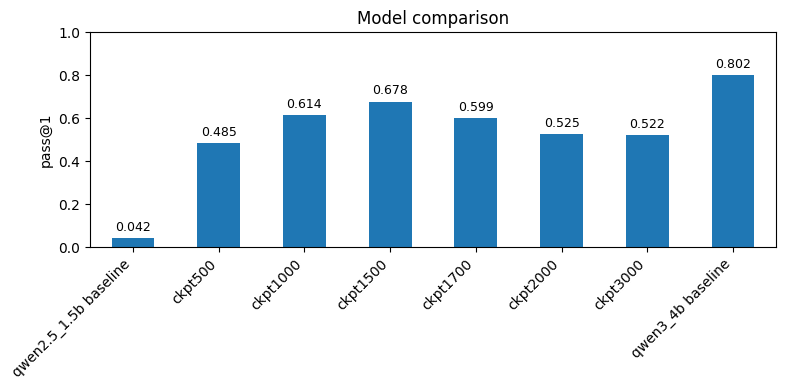

In [53]:
import re
import matplotlib.pyplot as plt

# Prepare data
df_plot = df[["model", "pass@n"]].copy()

def short_name(m):
    if "ckpt" in m:
        return re.search(r"(ckpt\d+)", m).group(1)
    return m.replace("_baseline", " baseline")

df_plot["label"] = df_plot["model"].apply(short_name)

# Plot
ax = df_plot.plot(
    x="label",
    y="pass@n",
    kind="bar",
    legend=False,
    figsize=(8, 4)
)

ax.set_ylabel("pass@1")
ax.set_title("Model comparison")
ax.set_ylim(0, 1)

# Add values on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.3f}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=9,
        xytext=(0, 3),
        textcoords="offset points",
    )

ax.set_xlabel("")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


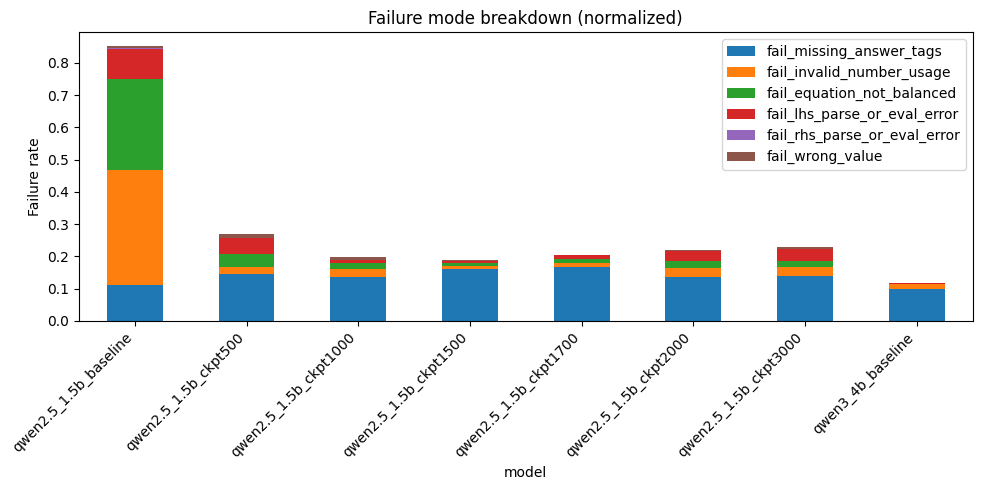

In [58]:
fail_cols = [c for c in df.columns if c.startswith("fail_")]

fail_df = df[fail_cols].div(df["valid_rows"], axis=0)

fail_df.index = df["model"]

fail_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 5)
)

plt.ylabel("Failure rate")
plt.title("Failure mode breakdown (normalized)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


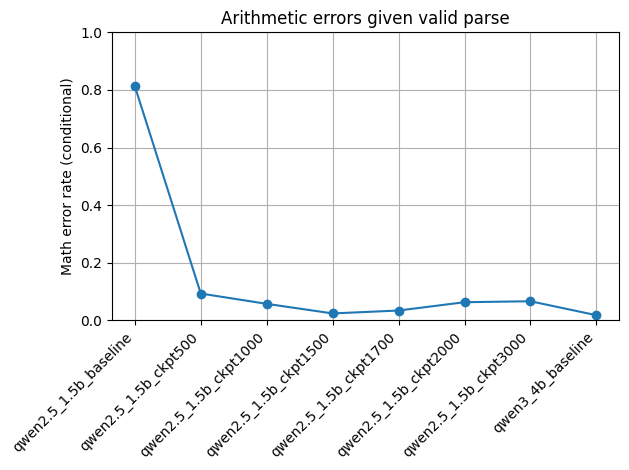

In [59]:
parsable = df["valid_rows"] - (
    df["fail_missing_answer_tags"]
    + df["fail_lhs_parse_or_eval_error"]
    + df["fail_rhs_parse_or_eval_error"]
)

math_fail = (
    df["fail_wrong_value"]
    + df["fail_equation_not_balanced"]
    + df["fail_invalid_number_usage"]
)

math_error_rate = math_fail / parsable

plt.figure()
plt.plot(df["model"], math_error_rate, marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Math error rate (conditional)")
plt.title("Arithmetic errors given valid parse")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()